In [1]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [2]:
import pandas as pd
df = pd.DataFrame(california.data, columns=california.feature_names)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [3]:
import numpy as np
from scipy.stats import zscore

# Список колонок для перевірки на аномалії
cols = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
threshold = 3
z_scores = df[cols].apply(zscore)
mask = np.abs(z_scores) < threshold
rows_to_keep = mask.all(axis=1)
df_clean = df[rows_to_keep].copy()
print("Початковий розмір даних:", df.shape)
print("Розмір після видалення викидів:", df_clean.shape)


Початковий розмір даних: (20640, 8)
Розмір після видалення викидів: (20135, 8)


Матриця кореляцій:
              MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc      1.000000 -0.115877  0.656478  -0.167024   -0.020473 -0.062207   
HouseAge   -0.115877  1.000000 -0.215724  -0.125943   -0.289941 -0.000518   
AveRooms    0.656478 -0.215724  1.000000   0.300095   -0.086841 -0.042819   
AveBedrms  -0.167024 -0.125943  0.300095   1.000000   -0.045160 -0.081026   
Population -0.020473 -0.289941 -0.086841  -0.045160    1.000000  0.177735   
AveOccup   -0.062207 -0.000518 -0.042819  -0.081026    0.177735  1.000000   
Latitude   -0.078484  0.009358  0.120207   0.067959   -0.118249 -0.139507   
Longitude  -0.016496 -0.101218 -0.073539   0.012771    0.107183  0.148333   

            Latitude  Longitude  
MedInc     -0.078484  -0.016496  
HouseAge    0.009358  -0.101218  
AveRooms    0.120207  -0.073539  
AveBedrms   0.067959   0.012771  
Population -0.118249   0.107183  
AveOccup   -0.139507   0.148333  
Latitude    1.000000  -0.927871  
Longitude  -0.9

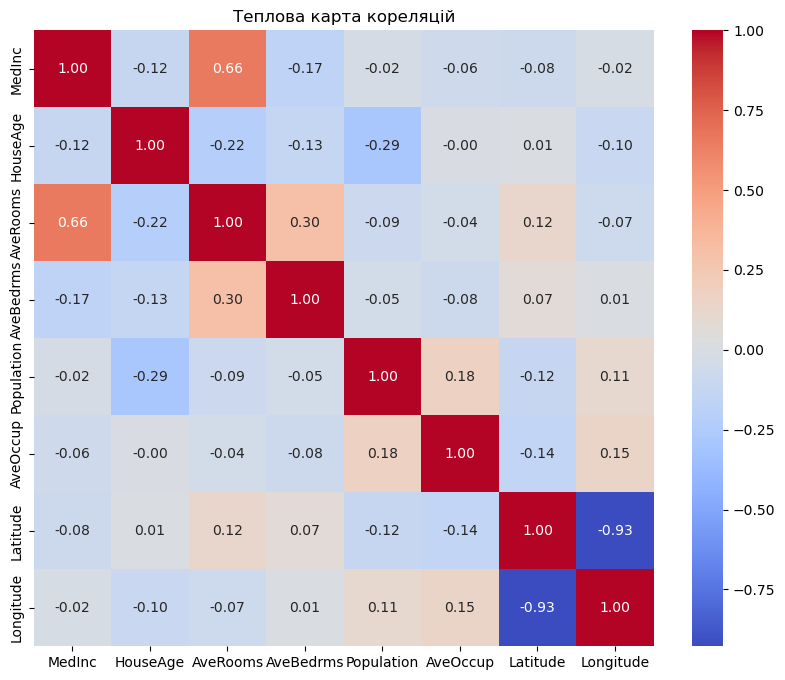

In [4]:
import seaborn as sns  
import matplotlib.pyplot as plt  # для побудови графіків
correlation_matrix = df_clean.corr()
print("Матриця кореляцій:")
print(correlation_matrix)

# Створюємо теплову карту (heatmap) для зручного перегляду кореляцій
plt.figure(figsize=(10, 8))  # налаштовуємо розмір графіка
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Теплова карта кореляцій")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Припустимо, що df_clean вже містить ваші очищені дані 
# і MedInc - це цільова змінна

# Розділяємо дані на ознаки (X) та ціль (y)
X = df_clean.drop(columns=["MedInc"])
y = df_clean["MedInc"]

# Розбиваємо на навчальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------------
# 1) Звичайна лінійна регресія (без поліноміальних ознак)
# -------------------------------------------------

# Створюємо копію, щоб не заплутатися з перетвореннями
X_train_lin = X_train.copy()
X_test_lin = X_test.copy()

# Масштабуємо дані
scaler_lin = StandardScaler()
X_train_lin_scaled = scaler_lin.fit_transform(X_train_lin)
X_test_lin_scaled = scaler_lin.transform(X_test_lin)

# Створюємо модель лінійної регресії
lin_model = LinearRegression()
# Навчаємо
lin_model.fit(X_train_lin_scaled, y_train)
# Передбачаємо
y_pred_lin = lin_model.predict(X_test_lin_scaled)

# Обчислюємо метрики
r2_lin = r2_score(y_test, y_pred_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)

print("=== Лінійна регресія (без поліноміальних ознак) ===")
print(f"R2: {r2_lin:.2f} | MAE: {mae_lin:.2f} | MAPE: {mape_lin:.2f}\n")

# -------------------------------------------------
# 2) Лінійна регресія з поліноміальними ознаками
# -------------------------------------------------

poly_degree = 2
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)

# Генеруємо поліноміальні ознаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Масштабуємо поліноміальні ознаки
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

# Створюємо модель лінійної регресії для поліноміальних ознак
poly_model = LinearRegression()
# Навчаємо
poly_model.fit(X_train_poly_scaled, y_train)
# Передбачаємо
y_pred_poly = poly_model.predict(X_test_poly_scaled)

# Обчислюємо метрики
r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly)

print(f"=== Поліноміальна регресія (ступінь = {poly_degree}) ===")
print(f"R2: {r2_poly:.2f} | MAE: {mae_poly:.2f} | MAPE: {mape_poly:.2f}")

=== Лінійна регресія (без поліноміальних ознак) ===
R2: 0.66 | MAE: 0.79 | MAPE: 0.25

=== Поліноміальна регресія (ступінь = 2) ===
R2: 0.74 | MAE: 0.71 | MAPE: 0.22


### Висновки

1. Вплив аутлаєрів (викидів). Порівняння результатів до та після видалення аномальних значень показує, що очищення даних суттєво покращує показники моделі (R², MAE, MAPE).
* До очищення: R² коливалося в діапазоні ~0.55–0.56.
* Після очищення: R² зросло до ~0.66–0.74 залежно від методу (лінійна vs. поліноміальна регресія).
* Це свідчить, що аутлаєри вносили «шум» і гірше «підлаштовувалися» під базову лінійну модель.
2. Роль географічних ознак (Latitude, Longitude або будь-які їх похідні). Видалення географічних ознак знижує результативність: R² падає з ~0.66/0.74 до ~0.59/0.68, а похибки (MAE, MAPE) зростають.
* Географічні ознаки дійсно несуть суттєву інформацію про розташування житла і, ймовірно, корелюють з важливими факторами (наприклад, близькість до узбережжя, міста тощо).
3.	Порівняння лінійної та поліноміальної регресії.
* Поліноміальна регресія (ступінь = 2) дає кращий R².
* $R^2$ зростає з 0.66 (лінійна) до 0.74 (поліноміальна), MAE знижується з 0.79 до 0.71, а MAPE — з 0.25 до 0.22.
* Підвищення полінома до степені 3 дає ще 2 відсотки до $R^2$ однак це також ускладнює модель, тут треба додаткові виміри, ефективності моделі. 